# Libraries

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import time

start_time = time.time()  # Start time

# Data

In [70]:
my_frac=0.1

# Load dataset as pandas DataFrame
df_train = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_train.parquet')
df_test = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_test.parquet')  

# Create sample DataFrame for feature selection
df_train_sample = df_train.sample(frac=my_frac, random_state=1984)      
df_test_sample = df_test.sample(frac=my_frac, random_state=1984)   

# Create sample X and y from train and test, convert to numpy arrays
X_train_sample = df_train_sample.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
y_train_sample_2 = df_train_sample['class_label'].to_numpy()
y_train_sample_6 = df_train_sample['category_label'].to_numpy()
y_train_sample_19 = df_train_sample['attack_label'].to_numpy()


X_test_sample = df_test_sample.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
y_test_sample_2 = df_test_sample['class_label'].to_numpy()
y_test_sample_6 = df_test_sample['category_label'].to_numpy()
y_test_sample_19 = df_test_sample['attack_label'].to_numpy()


# Create full data X and y from train and test, convert to numpy arrays
X_train_full = df_train_sample.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
y_train_full_2 = df_train_sample['class_label'].to_numpy()
y_train_full_6 = df_train_sample['category_label'].to_numpy()
y_train_full_19 = df_train_sample['attack_label'].to_numpy()


X_test_full = df_test_sample.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
y_test_full_2 = df_test_sample['class_label'].to_numpy()
y_test_full_6 = df_test_sample['category_label'].to_numpy()
y_test_full_19 = df_test_sample['attack_label'].to_numpy()

# GA

This function evaluates the fitness of an individual (a potential solution) in a genetic algorithm by selecting features based on the individual's genes. Here’s what happens:

__Feature Selection__: The individual's genes (binary values) determine which features to select for training. If a gene is greater than 0.5, the corresponding feature is selected.

__Empty Set Check__: If no features are selected, the function returns a fitness score of 0 to avoid training on an empty feature set.

__Model Training__: A Random Forest classifier is trained on the selected features using the training dataset.

__Prediction__: The trained model predicts labels for the test dataset using the same selected features.

__Fitness Calculation__: The accuracy of the predictions is calculated, which serves as the fitness score of the individual. This score represents how well the selected feature subset performs in classification.

The higher the accuracy, the better the individual's solution.

### Random Forest Benchmark

In [71]:
rf_benchmark = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    min_samples_split=2, 
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    min_impurity_decrease=0.0,
    bootstrap=True, 
    oob_score=False, 
    warm_start=False, 
    ccp_alpha=0.0, 
    n_jobs=-1, 
    random_state=1984
    )

In [72]:
# define the fitness function for evaluating feature subsets
def fitness_function(individual, y_train_sample, y_test_sample, CLASSIFIER="rf", metric="accuracy"):
    # function selects the features based on the individual's genes - features with values > 0.5 are selected
    selected_features = np.where(individual == 1)[0]  # select features based on individual genes
    
    if len(selected_features) == 0:                   # avoid empty feature set
        return 0
    
    X_train_selected = X_train_sample[:, selected_features]
    X_test_selected = X_test_sample[:, selected_features]

    # in this conditions ignore part with 'lr' and 'AdaBoostClassifier'. It will be used for the full pipeline
    # but for this demonstration I use only 'rf' to make it run quicker 
    if CLASSIFIER == 'lr':
        lr = LogisticRegression(**lr_benchmark.get_params())
        lr.fit(X_train_selected, y_train_sample)
        y_pred = lr.predict(X_test_selected)

    elif CLASSIFIER == 'ada':
        ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=1984)
        ada.fit(X_train_selected, y_train_sample)               
        y_pred = ada.predict(X_test_selected) 
    
    elif CLASSIFIER == 'rf':
        rf = RandomForestClassifier(**rf_benchmark.get_params())
        rf.fit(X_train_selected, y_train_sample)               
        y_pred = rf.predict(X_test_selected) 

    # Calculate the chosen metric
    if metric == 'accuracy':
        score = accuracy_score(y_test_sample, y_pred)
    elif metric == 'precision':
        score = precision_score(y_test_sample, y_pred, average='weighted')
    elif metric == 'recall':
        score = recall_score(y_test_sample, y_pred, average='weighted')
    elif metric == 'f1':
        score = f1_score(y_test_sample, y_pred, average='weighted')
    else:
        raise ValueError("Invalid metric. Choose from 'accuracy', 'precision', 'recall', or 'f1'.")

    return score                                     # return accuracy as the fitness score

### GA Parameters

__population_size__: Defines the number of individuals in the population, each representing a potential solution. A larger population allows for broader exploration of the solution space.

__n_generations__: Sets the maximum number of iterations the algorithm can run, allowing the population to evolve over multiple generations to find an optimal solution.

__mutation_rate__: Specifies the probability that any gene within an individual will mutate, introducing variability and helping avoid local optima.

__fitnes_threshold__: Represents the target fitness level that the algorithm aims to achieve. If reached, the algorithm will terminate early.

__stagnation_limit__: Establishes how many generations can pass without any improvement in the best fitness score before the algorithm terminates. This helps prevent the algorithm from running unnecessarily if no progress is being made.

In [73]:
# Genetic Algorithm parameters
population_size = 10            # number of individuals in the population. HAS TO BE AN EVEN NUMBER!!!!!
n_generations = 5               # maximum number of generations
mutation_rate = 0.1             # probability of mutation
#fitness_threshold = 1          # fitness goal (threshold for stopping)
#stagnation_limit = 3           # number of generations without improvement before stopping
num_elites = 2                  # number of elite individuals to keep in each generation

The code first determines the number of features in the dataset to define the length of each individual in the population. Then, it initializes a population of random individuals, where each individual is represented by a vector with values between 0 and 1, indicating potential feature subsets. Additionally, variables are set up to track the best fitness score and the corresponding individual across generations. A counter for the number of generations without improvement is also initialized, along with a variable to store the reason for the algorithm's termination.

In [74]:
# get the number of features for individual length
n_features = X_train_sample.shape[1]   # number of features in dataset (45)

# initialize population with random values between 0 and 1 (individuals represent feature subsets)
# population = np.random.rand(population_size, n_features)
population = np.random.randint(2, size=(population_size, n_features))

# initialize variables to track the best fitness and stagnation count
best_fitness_overall = 0
best_individual_overall = None
no_improvement_count = 0
termination_reason = None  # To store the reason for termination

The main loop of the genetic algorithm runs through each generation, evaluating feature selection, updating the population, and checking for termination conditions.

__Fitness Evaluation__:
For each individual in the population, a fitness score is calculated based on feature selection using the function evaluate_feature_selection.
The current best fitness score and the corresponding individual (feature subset) are tracked for each generation.

__Generation Statistics__:
For every generation, the algorithm prints the best fitness score achieved.

__Updating Best Individual__:
If the current generation produces a better fitness score than the overall best, it updates the best individual and resets the stagnation counter (which tracks the number of generations without improvement).
If no improvement is found, the stagnation counter increases.

__Termination Checks__:
The algorithm checks two termination conditions:
Fitness Threshold: If the best fitness score reaches or exceeds a pre-set threshold, the loop breaks, and termination is triggered.
Stagnation: If there is no improvement in fitness for a predefined number of generations, the algorithm terminates early.

__Selection__:
Using roulette wheel selection based on fitness scores, a new population is created from the current individuals. The likelihood of selection is proportional to the fitness of each individual.

__Crossover__:
Pairs of selected individuals undergo single-point crossover, combining their genes to produce offspring. Each pair of parents creates two children by swapping their genes at a random crossover point.

__Mutation__:
Each gene in the offspring has a chance of mutation, where a random bit is flipped (changing from 0 to 1 or vice versa) based on a predefined mutation rate.

__Population Update__:
The current population is replaced by the newly generated offspring, and the algorithm proceeds to the next generation.

__Termination Reason__:
If the termination criteria are met (fitness threshold or stagnation), the loop breaks early, and the reason is printed. If the loop completes all generations without early termination, the reason will be the maximum number of generations reached.
This process continues until one of the termination criteria is satisfied, determining how long the algorithm runs and what feature subset is ultimately chosen.

In [75]:
# Genetic Algorithm main loop for feature selection
for generation in range(n_generations):
    
    # printing population at the start of each loop
    print(f"LOOP STEP: Generation {generation + 1}")
    print(f"Population {generation + 1}: {population}")
    
    # using fitness_function (defined above) to calculate fitness score (accuracy, f1 ...) for each individual in population
    fitness_scores = np.array([fitness_function(individual, y_train_sample=y_train_sample_2, y_test_sample=y_test_sample_2) for individual in population])
    
    ### PROGRESS UPDATE: display calculated fitness scores
    print(f"Fitness Scores: {fitness_scores}") 

    # track the best fitness score in the current generation. 
    # will be used later on test dataset as the best subset of features
    current_best_fitness = np.max(fitness_scores)
    current_best_individual = population[np.argmax(fitness_scores)]
    
    # count the number of selected features (those with values > 0.5)
    num_selected_features = np.sum(current_best_individual > 0.5)
    
    ### PROGRESS UPDATE: print generation stats including number of selected features
    print(f"Best Fitness = {current_best_fitness:.7f}, Number of Features = {num_selected_features}, Selected Features = {current_best_individual}")
    
    # update the overall best fitness and individual if necessary
    best_fitness_overall = current_best_fitness
    best_individual_overall = current_best_individual

    # update the overall best fitness and individual if necessary
    #if current_best_fitness > best_fitness_overall:
    #    best_fitness_overall = current_best_fitness
    #    best_individual_overall = current_best_individual
    #    no_improvement_count = 0  # reset stagnation counter if there's improvement
    #else:
    #    no_improvement_count += 1  # increase stagnation counter if no improvement

    ### PROGRESS UPDATE: print current state of best model
    print(f"Overall best fitness: {best_fitness_overall:.7f}, Overall best individual: {best_individual_overall}") 
    
    
    ###___________________START___________________###
    ### this 2 criteria were introduced to increase efficiency and terminate loop earlier.
    ### At this stage I am not entirely sure it is neceassary nor they work properly.
    ### will keep it commented out for now.

    # check if the fitness threshold is reached
    #if best_fitness_overall >= fitness_threshold:
    #    termination_reason = f"Desired fitness threshold of {fitness_threshold} reached."
    #    break
    
    # check if there's been no improvement for stagnation_limit generations
    #if no_improvement_count >= stagnation_limit:
    #    termination_reason = f"No improvement for {stagnation_limit} generations."
    #    break
    ###___________________END_____________________###


    ###___________________START___________________###
    # The purpose of this block of code to narrow down the individuals to those that have better fitness, 
    # creating a more fit population for the next generation. It mimics the principle of “survival of the fittest,” 
    # where better-performing individuals have a greater chance of reproducing.

    # Selection: roulette wheel selection based on fitness (the better individual's fitness score the more probability to be selected)
    probabilities = fitness_scores / np.sum(fitness_scores)
    ### PROGRESS UPDATE: print probabilities
    print(f"Probabilities: {probabilities}")

    # Randomly selects individuals with replacement, using the probabilities array to bias the selection
    selected_indices = np.random.choice(np.arange(population_size), size=population_size, p=probabilities)
    ### PROGRESS UPDATE: print selected indicies
    print(f"Selected indicies: {selected_indices}")

    # creating a new array that contains only the chosen individuals from the current generation.
    selected_population = population[selected_indices]
    ### PROGRESS UPDATE: print new population
    print(f"Selected population: {selected_population}")
    ###___________________END_____________________###


    
    ###___________________START___________________###
    # ELITISM:
    # technique used to preserve the best solutions (individuals) from one generation to the next. 
    # It helps ensure that the best-found solutions so far are not lost during the evolution process.

    elite_indices = np.argsort(fitness_scores)[-num_elites:]
    ### PROGRESS UPDATE: print new population
    print(f"Elites indicies: {elite_indices}")

    elite_population = population[elite_indices]
    ### PROGRESS UPDATE: print elite individuals
    print(f"Elites individuals: {elite_population}")
    ###___________________END_____________________###


    ###___________________START___________________###
    # Crossover: single-point crossover. The goal is to blend the genetic material of two parents 
    # in such a way that the offspring may inherit the best traits (features in this case) from each parent, 
    # promoting better solutions in future generations.

    offspring = []
    # the loop goes through pair of individuals iterating by 2
    for i in range(0, population_size, 2):
        # selecting 2 consequntive individuals as parents
        parent1, parent2 = selected_population[i], selected_population[i+1]
        ### PROGRESS UPDATE: parents 
        print(f"Parent 1: {parent1}; Parent 2: {parent2}")

        # randomely defines where the “split” between the parents’ genes will occur
        crossover_point = np.random.randint(1, n_features-1)
        ### PROGRESS UPDATE: crossover point
        print(f"Crossover_point: {crossover_point}")

        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        ### PROGRESS UPDATE: children 
        print(f"Child 1: {child1}; Child 2: {child2}")
        
        offspring.extend([child1, child2])
    
    # The two newly created children are added to the offspring list using offspring.extend
    # Ensure correct size by trimming excess if necessary
    offspring = np.array(offspring[:population_size - num_elites])  # Ensure correct size by trimming excess if necessary
    ###___________________END___________________###

    

    ###___________________START___________________### 
    # MUTATION:
    # Flip features value (0 or 1) with a probability of mutation_rate and introduces diversity to the population 
    # by altering some genes in random locations, ensuring that the algorithm doesn’t rely only on existing solutions. 
    # This variation can help the algorithm escape local optima and explore a broader solution space, 
    # which is especially useful in complex optimization problems.
    for individual in offspring:
        # firstly create random values between 0 and 1 for each feature in individual, 
        # then compare to hyperparameter (mutation_rate) 
        # returning TRUE (less then hyperparameter value) or FALSE for each feature 
        mutation_mask = np.random.rand(n_features) < mutation_rate
        # PROGRESS UPDATE: mutation_mask
        print(f"Mutation mask: {mutation_mask}")

        # if TRUE the feature will mutate (flip from 0 to 1 of vice versa)
        individual[mutation_mask] = 1 - individual[mutation_mask]  # flip 0 to 1 or 1 to 0
        ###___________________END___________________###


    # Replace the population with offspring plus elite individuals
    population = np.vstack((elite_population, offspring))

### This statement relied on stagnation variable which is not in use, so commented out for now
# if no termination reason set, the loop ran for the maximum number of generations
#if termination_reason is None:
#    termination_reason = f"Reached maximum number of generations ({n_generations})."

# print termination reason
print(f"Termination Reason: {termination_reason}")

LOOP STEP: Generation 1
Population 1: [[0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0
  0 1 1 0 0 0 1 1 0]
 [0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0
  1 1 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0
  0 0 0 0 0 1 1 0 1]
 [0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0
  0 1 1 1 1 0 1 0 0]
 [1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1
  0 0 1 0 0 1 0 1 1]
 [1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1
  1 0 0 1 1 1 1 1 0]
 [0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1
  0 1 1 1 0 1 0 1 0]
 [1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1
  1 0 1 1 0 0 1 1 0]
 [1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0
  1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0
  1 0 0 1 1 1 0 0 0]]
Fitness Sco

In [76]:
print(f"Best Fitness Overall: {best_fitness_overall}; Number of Selected Features: {num_selected_features}; Best inidvidual Overall: {best_individual_overall}")

Best Fitness Overall: 0.9991946375249353; Number of Selected Features: 26; Best inidvidual Overall: [0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0
 1 1 1 1 1 1 1 0]


# Random Forest Classifier

In [77]:
# use the best features identified by GA
selected_features = np.array(best_individual_overall, dtype=bool)
# Apply the selected features to your datasets
X_train_selected = X_train_sample[:, selected_features]
X_test_selected = X_test_sample[:, selected_features]

rf_benchmark.fit(X_train_selected, y_train_sample_19) 
y_pred_rf_ga_19 = rf_benchmark.predict(X_test_selected)

In [78]:
# print the classification report
report_rf_ga_19 = classification_report(y_test_sample_19, y_pred_rf_ga_19, output_dict=True)
print(classification_report(y_test_sample_19, y_pred_rf_ga_19))

print(f"Number of selected features: {X_train_selected.shape[1]}")

# calculate accuracy
accuracy_rf_ga_19 = accuracy_score(y_test_sample_19, y_pred_rf_ga_19)

# print accuracy with 5 decimal places
print(f"Accuracy: {accuracy_rf_ga_19:.5f}")

                    precision    recall  f1-score   support

      ARP_spoofing       0.90      0.70      0.79       178
            Benign       0.96      1.00      0.98      3710
         DDoS_ICMP       1.00      1.00      1.00     34820
          DDoS_SYN       1.00      1.00      1.00     17378
          DDoS_TCP       1.00      1.00      1.00     18272
          DDoS_UDP       1.00      1.00      1.00     36376
DDoS_connect_flood       1.00      1.00      1.00      4190
DDoS_publish_flood       1.00      0.98      0.99       845
          DoS_ICMP       1.00      1.00      1.00      9886
           DoS_SYN       1.00      1.00      1.00      9906
           DoS_TCP       1.00      1.00      1.00      8182
           DoS_UDP       1.00      1.00      1.00     13683
 DoS_connect_flood       1.00      1.00      1.00       326
 DoS_publish_flood       0.97      1.00      0.99       797
    Malformed_date       0.99      0.76      0.86       174
           OS_scan       0.87      0.70

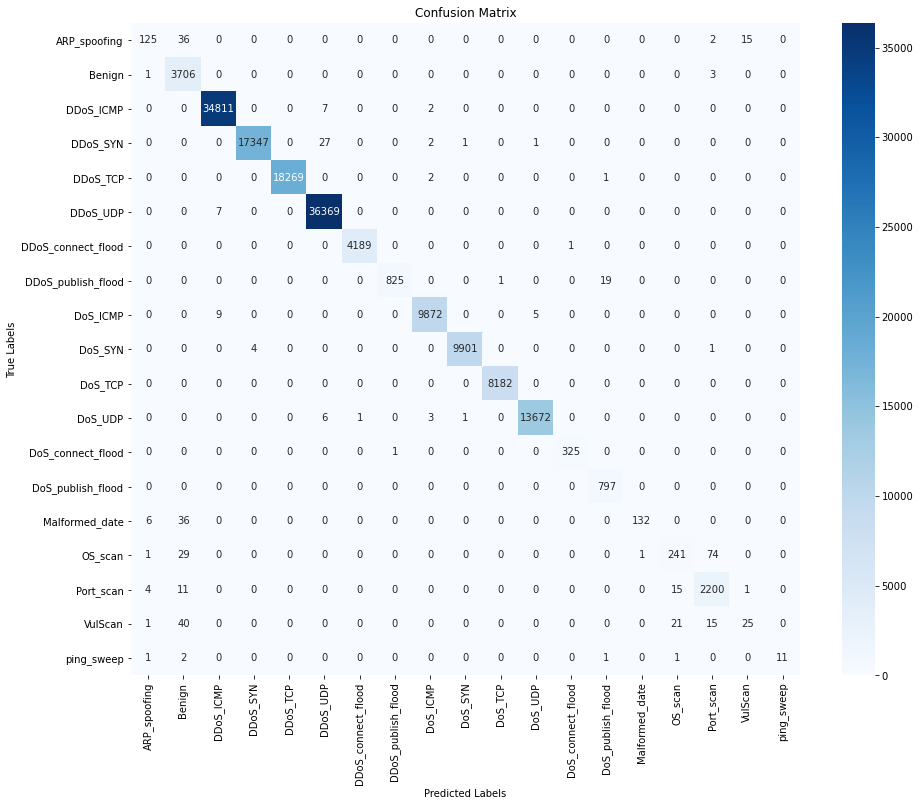

In [79]:
# generate the confusion matrix
cm_rf_ga_19 = confusion_matrix(y_test_sample_19, y_pred_rf_ga_19)

# visualize the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm_rf_ga_19, annot=True, fmt='d', cmap='Blues', xticklabels=rf_benchmark.classes_, yticklabels=rf_benchmark.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [80]:
end_time = time.time()  # End time
elapsed_time = end_time - start_time  # Calculate the total time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Total execution time: 1246.79 seconds
